# How do Machines Learn?

If we want to teach a machine to learn, how do we do this? We must first come up with a model. This model is going to have some parameters, variables, that will need to be tuned to the task at hand. However, the obvious question is how do we tune these parameters? Clearly we must do this in a smart manner or else our machine will struggle to learn anything...

In broad strokes, any Machine Learning (ML) algorithm can be summarized with the following components:
 * A (parametrized) model
 * A learning algorithm
 * A learning objective
 
This lab is going to focus on the learning algorithm and learning objective aspects of machine learning before we delve into the realm of machine learning models.

In [1]:
from matplotlib import pyplot as plt
import torch

In [56]:
# Pretty plotting config
%run plot_conf.py

In [57]:
# Set style (need to be in a new cell)
plt_style()

# 1.0 - The Learning Objective & Model
The learning objective, simply put, is what we are trying to teach the machine to do. In more general terms, what we are typically given is some input data $\vec{X}$ that we are trying to use to map to some label or prediction $\vec{y}$. This could be trying to predict future stock market prices given past stock market prices, label images of animals, or identify particles produced at the Large Hadron Collider. In each example given, we have some samples, $\vec{x}$, from our data, $\vec{X}$, that is readily available, $\vec{x} \in \vec{X}$, in which we are trying to use to create some predictions $\hat{y}$ that match our expected result $\vec{y}$ (ground truth).

In fact, what we are searching for is the relationship:
$$ \hat{y} = f\left(\vec{x}; \vec{\theta}\right) $$
where $f(\vec{x}; \vec{\theta})$ is some magical function that perfectly predicts the desired output. This magical function $f$ is the machine learning model which is parametrized by the vector of parameters $\vec{\theta}$. 

For now let's imagine the simple case of a 1D linear model with y-intercept set to zero:
$$ f\left(\vec{x}; \vec{\theta}\right) = \theta_1 \cdot x_1 $$
This model takes in a one dimensional vector and uses a one dimensional parameter vector to create a predicted output that is also one dimensional. This is quite possibly the simplest machine learning model!

Now let's build this model with PyTorch!

In [4]:
theta = torch.Tensor(1).random_(10) # generates 1 random integer between 0 and 9

In [5]:
theta

tensor([2.])

In [6]:
theta.requires_grad = True # keeps track of derivatives for learning algorithm later on

In [7]:
N = 10 # this is number of samples

In [8]:
x = (10 * torch.rand(N).reshape(N, 1))  # reshape is to ensure it is 10,000 samples of 1D vectors

In [9]:
slope = 4.928 # This is a parameter that our model needs to learn to predict accurately
y_intercept = -12.52 # This is another parameter that our model needs to learn to predict accurately
noise = torch.randn(N).reshape(N, 1) # in reality you always have some "noise" with your given data's "true" predicted outcome
#noise *= 2
y_true = slope * x + y_intercept # this is the ground truth model. TYPICALLY THIS IS NOT KNOWN
y_true = y_true + noise # let's add some noise to make it impossible to learn the model perfectly
y_pred = theta[0] * x # generate predictions by using model's parameters (theta) and data inputs (x)

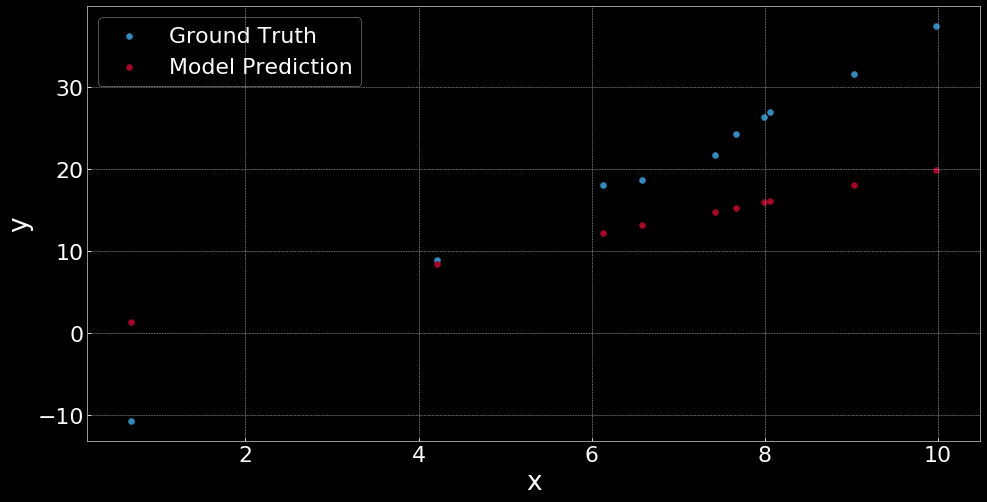

In [58]:
# need to call x.detach() to detach the x PyTorch Tensor from your GPU and load it into RAM
# need to call x.numpy() to convert PyTorch Tensor into NumPy Array so that Matplotlib is happy
# can chain them together --> x.detach().numpy()

# plot the ground truth y_true values, label='label here' is the label to be used in the legend
plt.scatter(x.detach().numpy(), y_true.detach().numpy(), label="Ground Truth") 

# plot the predicted y_pred values = f(x; theta)
plt.scatter(x.detach().numpy(), y_pred.detach().numpy(), label='Model Prediction')

# label the x axis
plt.xlabel('x')

# label the y axis
plt.ylabel('y')

# plot the legend
plt.legend()

# show the plot
plt.show()

Now clearly our model prediction varies greatly (is not correct) with respect to the ground truth. We need a way to score how incorrectly our model is predicting the output so that we can gauge how well our model is performing. To understand how to do this, we first need to understand what task it is we are trying to accomplish.
<br><br><br>
This task being described here is a regression task. This is because we are trying to predict a range of values, 0 to 40-ish in this case, as seen by the histogram below.

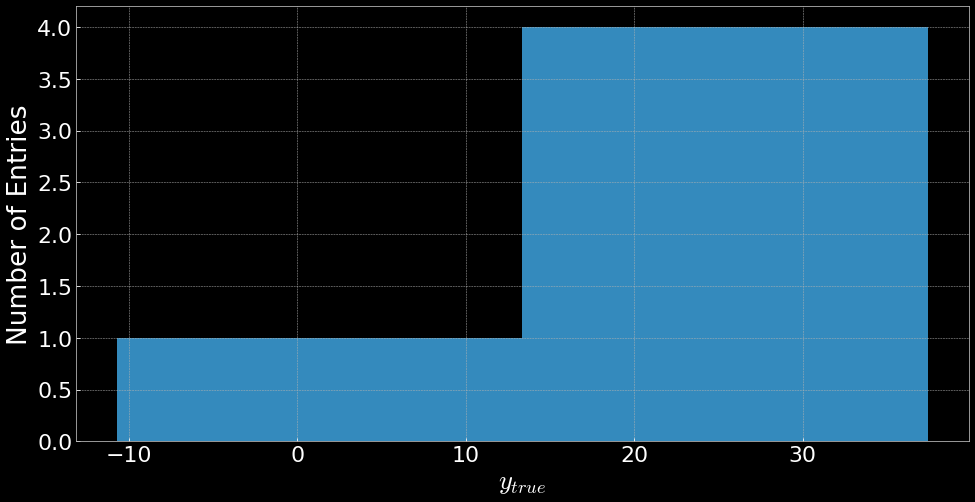

In [61]:
# histogram all of the ground truth y values
# this let's us see that the task at hand is to predict a continuous range of y values (regression)
# not some discrete y values corresponding to labels (classification)
plt.hist(y_true.detach().flatten(), bins=4)
plt.ylabel('Number of Entries')
plt.xlabel('$y_{true}$')
plt.show()

The other type of task that is typically performed with machine learning is classification. In classification tasks you are trying to classify or map inputs to a class, typically represented by 0 or 1 for binary classification or one-hot vectors for multiclass classification (0001, 0010, 0100, 1000 for 4 different classes, for example).
<br><br><br>
Since this is a regression task, we can just take the squared difference between the ground truth value and predicted value, which we will now call our loss function, $\mathcal{L}$.
$$
\mathcal{L}\left(\hat{y}, \vec{y}\right) = \mathcal{L}\left(f\left(\vec{x};\vec{\theta}\right), \vec{y}\right) = \frac{1}{2N}\sum_{i = 1}^{N} \sum_{j = 1}^D \left(\hat{y}_j^{\left(i\right)} - y_j^{\left(i\right)}\right)^2
$$
where N is the number of datapoints, D is the number of dimensions (1 in the above case), $\hat{y}$ are your predictions from your machine learning model, and $y$ are the ground truth values. This loss function is a difference since we need a measure of how different they are. This loss functions is also squared so that way it is positive definite. This means if the predicted value is larger than or less than the ground truth value we still incur a positive loss, which is the behavior we desire. We divide by N so that this is the average loss, which makes it easier to compare if you have varying numbers of samples (more on that later). 
<br><br><br>
The division by 2 is customary for making the learning algorithm calculations prettier which we will discuss shortly. You can cook up multiple different types of loss functions, which we will explore throughout this lab. This particular loss function is called the *mean squared error loss function* or MSE for short.

In [12]:
loss_per_datapoint = (y_true - y_pred).pow(2) # this computes the "loss" or "how bad the model is doing" per datapoint

In [13]:
# you can see that it computed the loss per data point, for all data points at once!
# This is represented by the fact that this is an array, where the loss_per_datapoints[i] corresponds
# to the ith data point's prediction error
loss_per_datapoint.shape

torch.Size([10, 1])

In [14]:
loss_per_datapoint

tensor([[ 33.7432],
        [ 80.7336],
        [305.9146],
        [ 47.5947],
        [146.2144],
        [108.9248],
        [  0.2444],
        [117.3863],
        [184.1901],
        [ 30.3959]], grad_fn=<PowBackward0>)

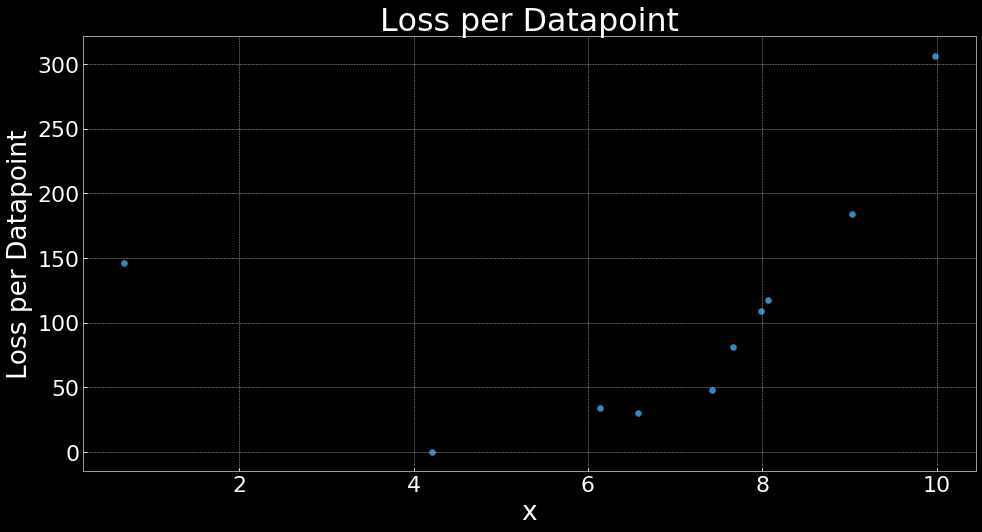

In [62]:
# Here I am plotting the loss per datapoint as a function of x
# This is so I can visualize how poorly my model is doing as a function of x
# You can see this roughly follows a quadratic dependence
# This is because our loss function is (y_pred - y_true)^2 = (theta * x - y_true)^2
# = (theta * x - (slope * x + y_intercept))^2 = ((theta - slope) * x - y_intercept)^2
# = (theta-slope)^2 x^2 - 2 * (theta-slope) * y_intercept * x + y_intercept^2

# maybe try adding the above formula to the plot below to convince yourself why this is the case
# The reason that there will be a scatter around this "theoretical" loss per datapoint is because
# y_true = slope * x + y_intercept + noise
# and noise is random so its "impossible" to model this behavior unless of course you know the
# exact noise that was added in

plt.scatter(x.detach(), loss_per_datapoint.detach(), label='Loss per Datapoint')
plt.title('Loss per Datapoint')
plt.ylabel('Loss per Datapoint')
plt.xlabel('x')
plt.show()

In [16]:
# In the above formula we need to sum over D and N
# We only have one value we are predicting so D = 1 and we are done there
# However, we still need to sum over N
loss = torch.sum(loss_per_datapoint) / (2 * N) # sum over N then divide by N to get average. Dividing by 2 is customary
print('average loss = ' + str(loss))

average loss = tensor(52.7671, grad_fn=<DivBackward0>)


So now we have a learning objective. Our learning objective is to create a machine learning model that has a loss of zero! Technically, the learning objective is the loss function itself, which is why we are free to choose what the learning objective/loss function is. Therefore, the next logical step we need to take is to figure out how to decrease this loss function in such a way that our model parameters become optimal. In other words, we need to figure out how to decrease the loss function with respect to our model parameters. If you have taken calculus before these words may be familiar....

# 2.0 The Learning Algorithm
So clearly we want to change the model parameters such that we start decreasing the loss function. In order to do this, we need to know how the loss function changes as we change the model parameters. In other words, we need a function of the form:

$$
\frac{\Delta\mathcal{L}}{\Delta\vec{\theta}} = g\left(\vec{\theta}; \vec{x} , \vec{y}\right)
$$

What this expression is saying is given some range of parameters, $\Delta\vec{\theta}$, this is how much on average $\Delta\mathcal{L}$ changes. Over that interval of $\Delta\vec{\theta}$, the loss function can go up and down, but we are simply just wondering how much it changed between the two endpoints. Now you may recall for a linear fuction $y = mx + b$, the slope, m, is equivalent to $\frac{\Delta y}{\Delta x}$. So really all this expression is asking for is the slope between two points on the loss function $\mathcal{L}$. $m = \frac{\Delta\mathcal{L}}{\Delta\vec{\theta}}$
<br><br>
However, we only have a single point on the loss function, namely:

In [17]:
print('The average loss is ' + str(loss) + ' at theta = ' + str(theta[0]))

The average loss is tensor(52.7671, grad_fn=<DivBackward0>) at theta = tensor(2., grad_fn=<SelectBackward>)


So the question becomes how can we know the *instantaneous* rate of change of the loss function at any given point? Or in other words, as we let the distance between the two $\theta$ values change, what does the slope approach? This slope would be the slope of the tangential line to the curve at the given value. Here's a nice animation showing this process. Note that in the denominator we simply have $\Delta x = (a + h) - (a) = h$ for this animation, so that we are evaluating the instantaneous rate of change at $x = a$.

![title](images/derivatives.gif)

This instantaneous rate of change of a function has a name and is called the derivative of a function. You will not need to know how to evaluate derivatives for this class, but just know that, for example, the derivative of $\mathcal{L} = \theta^2$ is $\frac{\partial \mathcal{L}}{\partial \theta} = 2\theta$. Since I have given you this information, you should be able to then plot tangent lines to any point along the curve $\mathcal{L}=\theta^2$, go ahead and try it out! 

In [63]:
def quadratic_tangents(theta):
    '''
    Compute the tangent line to the quadratic function loss = theta^2
    :param theta: The theta value to compute the tangent line at
    '''
    loss = theta ** 2.0 # compute the function L = theta^2
    m = 2 * theta # compute the derivative = 2 * theta
    
    # compute the y_intercept --> loss = m * theta + y_intercept --> y_intercept = loss - m * theta
    b = loss - m * theta
    
    # generate a bunch of thetas uniformly spaced by 0.01 between theta - 5 and theta + 5 for plotting
    thetas = np.arange(theta - 5, theta + 5, .01)
    
    # compute all of the y values for plotting with these thetas for our function L=theta^2 
    quadratic_ys = thetas ** 2
    
    # compute all of the y values for our tangent line at theta
    tangent_ys = m * thetas + b
    
    # plot the function y = theta^2, label needs to be r'label_here' to signify label is raw text
    # otherwise matploblib interprets \theta as \t heta = tab heta
    # this fancy stuff in labels is LaTeX
    plt.plot(thetas, quadratic_ys, label=r'$\mathcal{L} = \theta^2$')
    
    # plot the tangent line
    plt.plot(thetas, tangent_ys, label=r'Tangent line at $\theta$ = ' + str(theta))
    
    plt.xlabel(r'$\theta$')
    plt.ylabel('$\mathcal{L}$')
    # plot the legend
    plt.legend()
    
    plt.show()
    print('derivative at theta = ' + str(theta) + ' is ' + str(m))

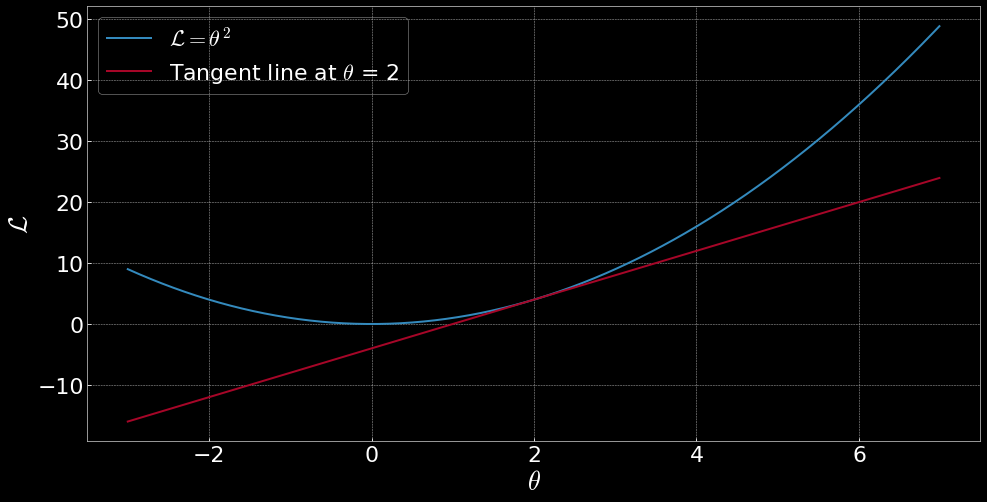

derivative at theta = 2 is 4


In [64]:
quadratic_tangents(2)

In [ ]:
# compute the tangent line at x = 0
# CODE GOES HERE
quadratic_tangents(____)

$\partial$ just means an infinitesimal amount, so an infinitesimal change in y would be $\partial y$. So we can take our previous loss function and actually calculate the derivative, the instantaneous rate of change of the loss function, with respect to $\theta$ at any arbitrarily given $\theta$ value! This means we now know how the loss function changes at a given $\theta$ value!
<br><br>
For completeness, I will give the derivative of our loss function for linear regression below
$$
\frac{\partial \mathcal{L}}{\partial \theta_1} = \frac{1}{2N}\sum_{i = 1}^{N} \sum_{j = 1}^D 2 \cdot \left(x^{\left(i\right)} \cdot \theta_1 - y_j^{\left(i\right)}\right) \cdot \left(x^{\left(i\right)} - y_j^{\left(i\right)}\right)
$$
<br><br>
Now maybe it is clear why that 1/2 out front is put there customarily. ;)
<br><br>

We are almost there to the learning algorithm! Now, by studying the above quadratic example, you may have noted that when the slope of the tangent line is positive, the minimum in $y=\theta^2$, which is at $\theta = 0$, can be achieved by decreasing $\theta$. Simiarly, when the slope of the tangent line is negative, the minimum is to the right of the given value. In other words, we need to increase the value of $\theta$ to achieve the minimum at $\theta=0$. As a concrete example, look at the derivative (slope of the tangent line) at $\theta=1.5$. This slope is positive. This means that we need to decrease $\theta$ to get to the minimum. The amount we need to decrease $\theta$ by is 1.5. Please note that at the minimum, the derivative/slope of the tangent line is zero! This is a very critical fact. Any minima or maxima of a function will always have the derivative be equal to zero at that point.
<br><br>
Now noting the above behavior, we may suggest that the way to "discover" the minima of a function is by simply subtracting the derivative from our given starting value:
$$
\theta_{t + 1} = \theta_t - \frac{\partial \mathcal{L}}{\partial \theta}
$$
So let's try that!

In [65]:
theta_0 = 1.5 # start at some initial theta value --> thetea at t = 0 is 1.5

for t in range(10): # for loop, goes over time from t = 0 to t = 9
    if t == 0: # set the theta_t equal to the initial theta, theta_0
        theta_t = theta_0
    else: # update theta
        tangent_slope = 2 * theta_t # tangent slope at point theta_t
        theta_t = theta_t - tangent_slope # theta_{t+1} = theta_t - dL/dtheta
    print('At time t = ' + str(t) + ', theta = ' + str(theta_t) + ', and the loss is ' + str(theta_t ** 2))

At time t = 0, theta = 1.5, and the loss is 2.25
At time t = 1, theta = -1.5, and the loss is 2.25
At time t = 2, theta = 1.5, and the loss is 2.25
At time t = 3, theta = -1.5, and the loss is 2.25
At time t = 4, theta = 1.5, and the loss is 2.25
At time t = 5, theta = -1.5, and the loss is 2.25
At time t = 6, theta = 1.5, and the loss is 2.25
At time t = 7, theta = -1.5, and the loss is 2.25
At time t = 8, theta = 1.5, and the loss is 2.25
At time t = 9, theta = -1.5, and the loss is 2.25


So clearly this does not work! What if instead of just subtracting the slope of the tangential line, we also multiply the slope by a number less than 1?

$$
\theta_{t + 1} = \theta_t - \alpha \frac{\partial \mathcal{L}}{\partial \theta}
$$

In [66]:
theta_0 = 1.5 # start at some initial theta value --> thetea at t = 0 is 1.5
alpha = 0.1 # alpha, the number we multiply the slope by

for t in range(10): # for loop, goes over time from t = 0 to t = 9
    if t == 0: # set the theta_t equal to the initial theta, theta_0
        theta_t = theta_0
    else: # update theta
        tangent_slope = 2 * theta_t # tangent slope at point theta_t
        theta_t = theta_t - alpha * tangent_slope # theta_{t+1} = theta_t - alpha * dL/dtheta
    print('At time t = ' + str(t) + ', theta = ' + str(theta_t) + ', and the loss is ' + str(theta_t ** 2))

At time t = 0, theta = 1.5, and the loss is 2.25
At time t = 1, theta = 1.2, and the loss is 1.44
At time t = 2, theta = 0.96, and the loss is 0.9216
At time t = 3, theta = 0.768, and the loss is 0.589824
At time t = 4, theta = 0.6144000000000001, and the loss is 0.37748736000000005
At time t = 5, theta = 0.49152000000000007, and the loss is 0.24159191040000005
At time t = 6, theta = 0.39321600000000007, and the loss is 0.15461882265600005
At time t = 7, theta = 0.31457280000000004, and the loss is 0.09895604649984002
At time t = 8, theta = 0.25165824000000003, and the loss is 0.06333186975989762
At time t = 9, theta = 0.20132659200000003, and the loss is 0.04053239664633448


We see now that the loss is decreasing! Let's now try plotting this...

In [76]:
def derivative_descent(theta=1.5, T=10, alpha=0.01):
    '''
    Function that will descend L = theta^2 for some initial theta value (theta), number of time steps (T) and 
    amount to multiply tangent slope by (alpha).
    
    :param theta: The initial starting value of theta at t = 0
    :param T: The number of time steps to perform.
    :param alpha: The number less than 1 to multiply the slope of the tangent line by.
    '''
    
    # generate theta values between [-|theta_0| - 0.5, |theta_0| + 0.5] in steps of 0.01 for plotting
    thetas = np.arange(-abs(theta) - 0.5, abs(theta) + 0.5, .01)
    
    # compute the cost function 
    quadratic_ys = thetas ** 2
    plt.plot(thetas, quadratic_ys, label=r'$\mathcal{L} = \theta^2$')
    
    # store the value of theta at different time steps and the corresponding loss
    theta_ts = [] # theta at different time steps
    L_ts = [] # corresponding loss
    
    tangent_thetas = np.array([]) # the theta values used to plot the tangent lines
    tangent_ys = np.array([]) # the y-axis values for the tangent lines

    for t in range(T): # perform T time steps
        if t == 0: # set the variables to their initial value
            theta_t = theta
            theta_ts.append(theta_t)
            L_ts.append(theta_t ** 2)
        else:
            if theta_t > 0: # we need to plot tangent line to the left over interval delta_theta
                derivative = 2 * theta_t
                delta_theta = np.arange(theta_t - alpha * derivative, theta_t, 0.001)
            else: # we need to plot tangent line to the right over interval delta_theta
                derivative = 2 * theta_t
                delta_theta = np.arange(theta_t, theta_t - alpha * derivative, 0.001)
                
            # concatenate the previous time steps tangent thetas with this new tangent thetas
            tangent_thetas = np.concatenate((tangent_thetas, delta_theta))
            
            # compute the y-intercept for this tangent line at time step t
            L = theta_t ** 2.0
            m = 2 * theta_t
            b = L - m * theta_t
            
             # compute my y values for my tangent line and concatenate previous time steps y-axis values
            tangent_ys = np.concatenate((tangent_ys, m * delta_theta + b))
            
            if t == 1: # add label for legend and plot tangent line on first round through
                plt.plot(delta_theta, m * delta_theta + b, label='Tangent lines', color='purple', linewidth=4.0)
            else: # otherwise just plot the tangent line
                plt.plot(delta_theta, m * delta_theta + b, color='purple', linewidth=4.0)
            
            theta_t -= alpha * 2 * theta_t # update theta
            theta_ts.append(theta_t) # add new theta to list of thetas at different time steps
            L_ts.append(theta_t ** 2.0) # add new loss for corresponding new theta value
    
    # plots the theta values that were computed at different time steps
    plt.scatter(theta_ts, L_ts, label=r'$\theta$ at different time steps', color='r', s=100)
    plt.xlabel(r'$\theta$')
    plt.ylabel('$\mathcal{L}$')
    plt.legend()
    plt.show()

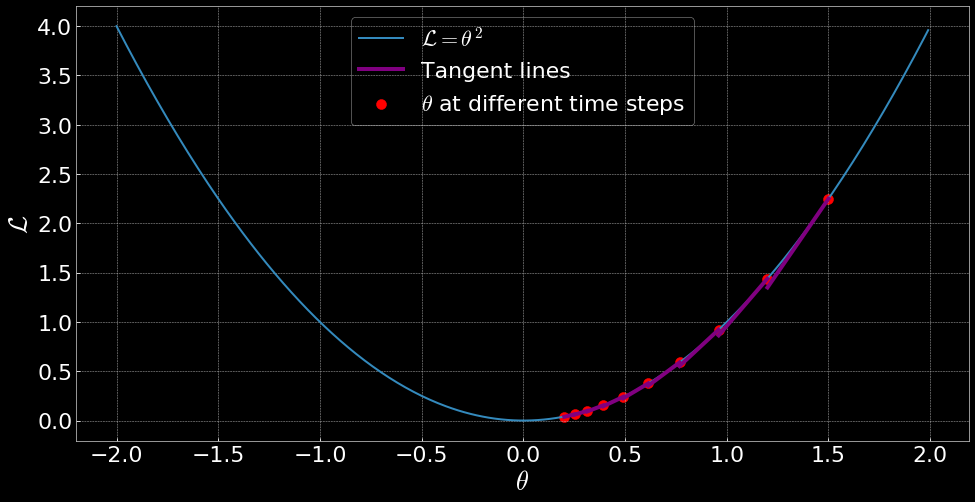

In [77]:
derivative_descent(theta=1.5, T=10, alpha=0.1)

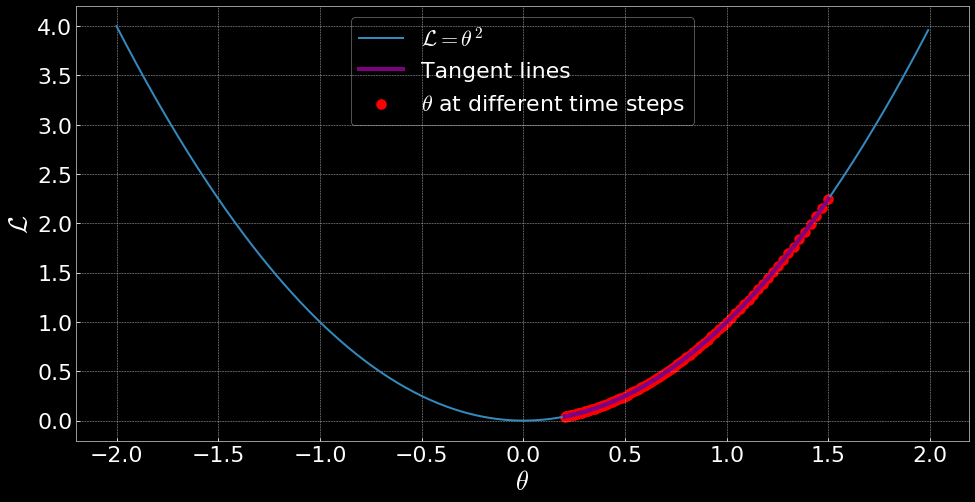

In [78]:
derivative_descent(theta=1.5, T=100, alpha=0.01)

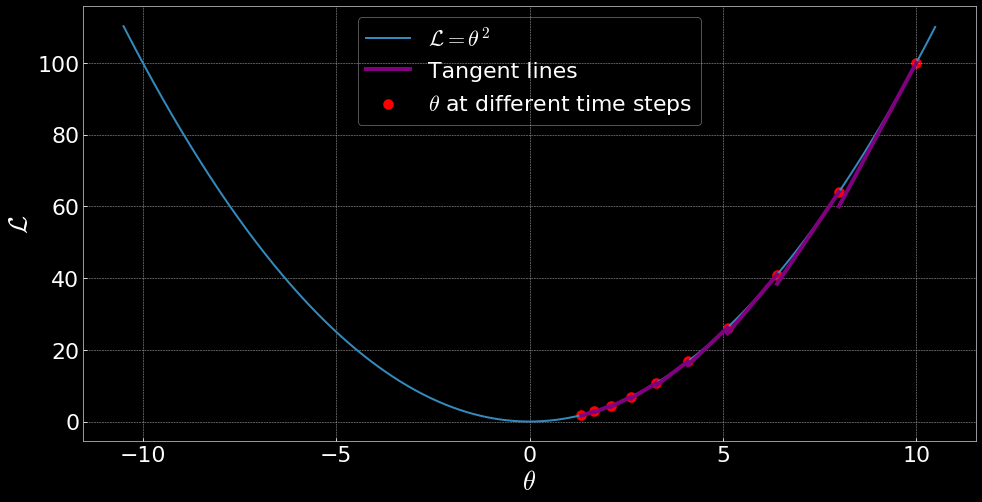

In [84]:
derivative_descent(theta=10, T=10, alpha=0.1)

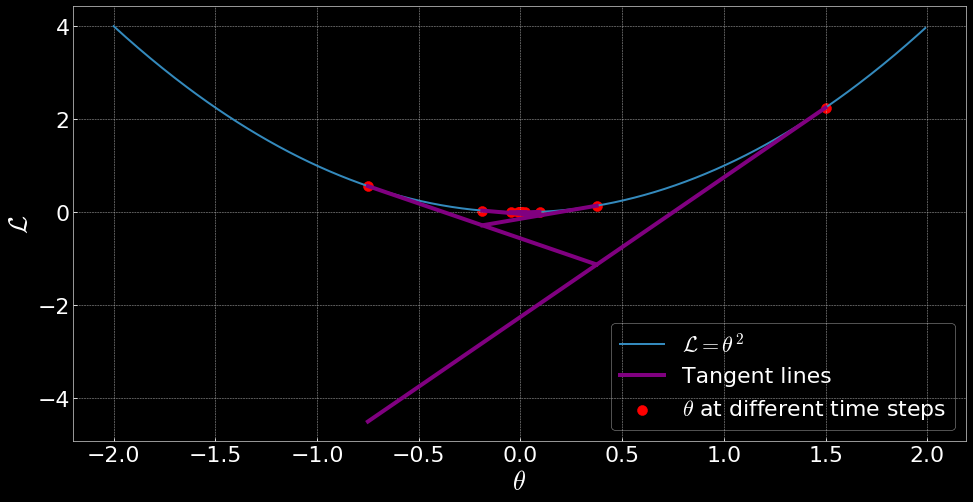

In [79]:
derivative_descent(theta=1.5, T=100, alpha=0.75)

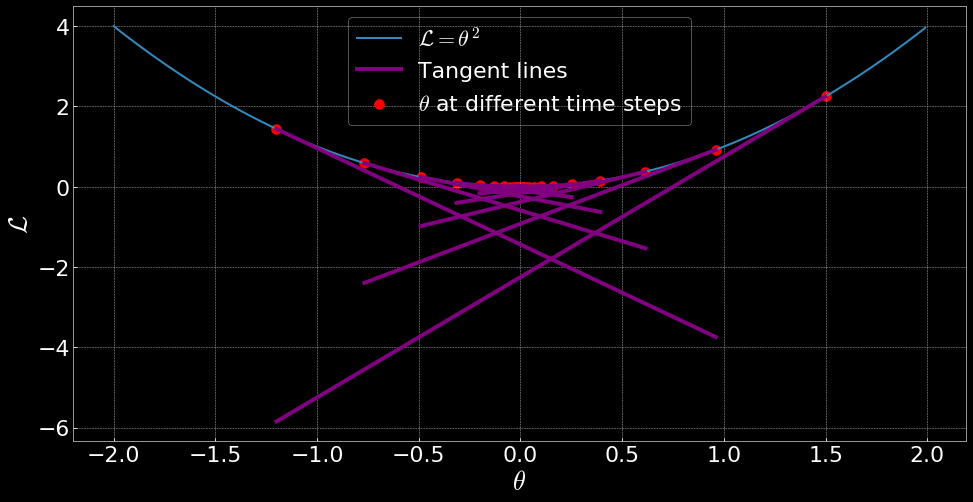

In [80]:
derivative_descent(theta=1.5, T=100, alpha=0.9)

We have discovered our first learning algorithm!

$$
\theta_{1, t + 1} = \theta_{1, t} - \alpha \frac{\partial \mathcal{L}}{\partial \theta_1}
$$
This parameter $\alpha$ actually has a name and is called the **learning rate**. From the above plots you may have noticed that with a very small learning rate the number of time steps required to reach the minimum increases. This parameter is special in the sense that this is a parameter we much choose for our machine learning application, but it is not a parameter of the model. Parameters that fall in this class are called *hyperparameters* and will be a subject of further discussion.

So now that we have our first learning algorithm, let's try it out! One nice thing about PyTorch is we don't have to worry about the computation of the derivative. We can simply call `loss.backward()` and what this does is it lets us calculate the derivative of the loss with respect to any variable by calling `variable.grad`!

In [85]:
loss.backward() # let's us calculate the derivative of the loss with respect to any variable

In [86]:
x.grad # dL/dx 

In [89]:
theta.grad # dL/dtheta

tensor([-65.3791])

Let's now train our linear regression model!

In [90]:
# training loop
losses = [] # a list to store our loss at each time step
learning_rate = 0.001

for t in range(100): # iterate through time steps updating our model's parameters at each time step
    y_pred = theta[0] * x # calculate our model's predicted y values for all of the x values
    loss_per_datapoint = (y_true - y_pred).pow(2) # compute the loss per data point on our predicted y values
    loss = torch.sum(loss_per_datapoint) / (2 * N) # compute the average loss over the entire dataset
    losses.append(loss) # add the average loss to our list of losses
    
    loss.backward() # perform "back-prop" -> calculate the derivative of the loss with respect to all the variables
    theta.data -= learning_rate * theta.grad.data # theta_{t+1} = theta_t - learning_rate * dL/dtheta
    theta.grad = None # zero out/set to null the theta derivatives so we can recompute them

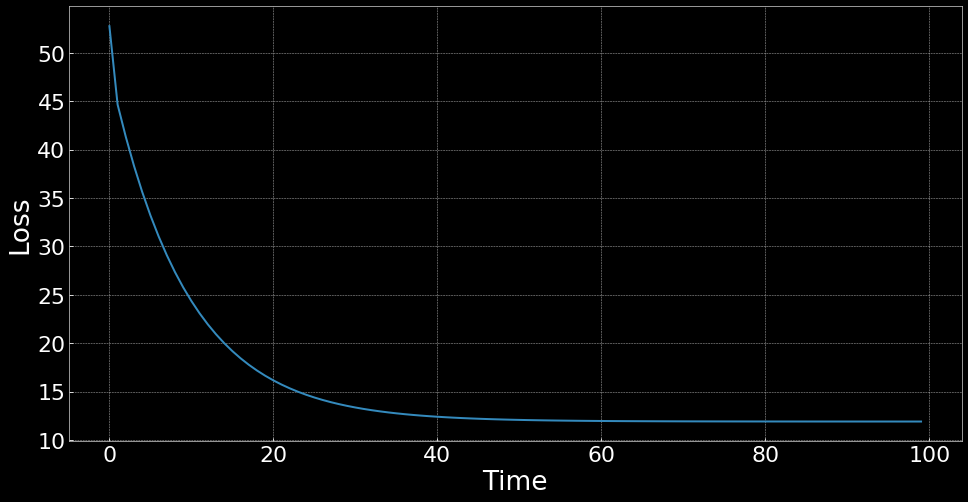

In [91]:
t = np.arange(0, len(losses), 1) # generate time steps from t = 0 to t = len(losses) in steps of 1

plt.plot(t, losses)
plt.ylabel('Loss')
plt.xlabel('Time')
plt.show()

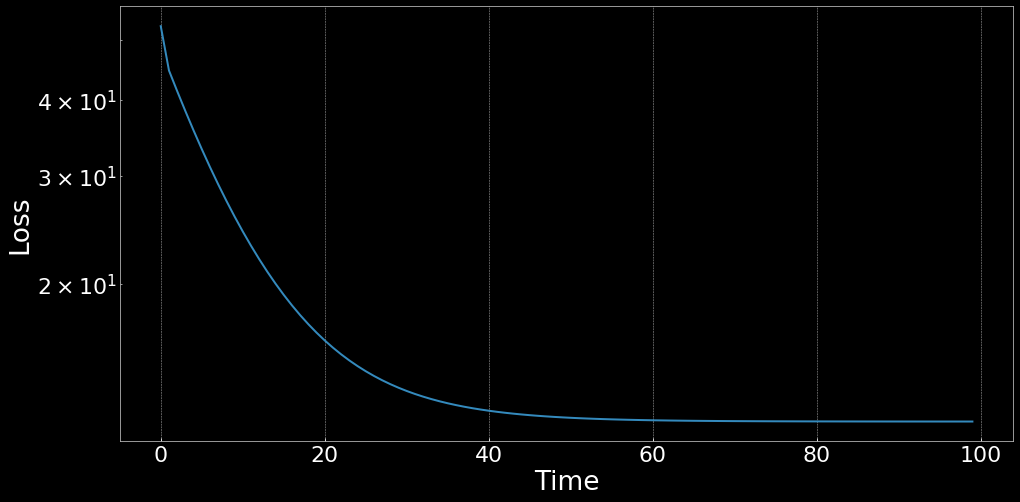

In [92]:
# loss can sometimes be deceiving 
# Need to look at it on a log scale to see if it is still improving!

t = np.arange(0, len(losses), 1) # generate time steps from t = 0 to t = len(losses) in steps of 1

plt.plot(t, losses)
plt.ylabel('Loss')
plt.xlabel('Time')
plt.yscale('log') # Set the y-axis scale to logarithm
plt.show()

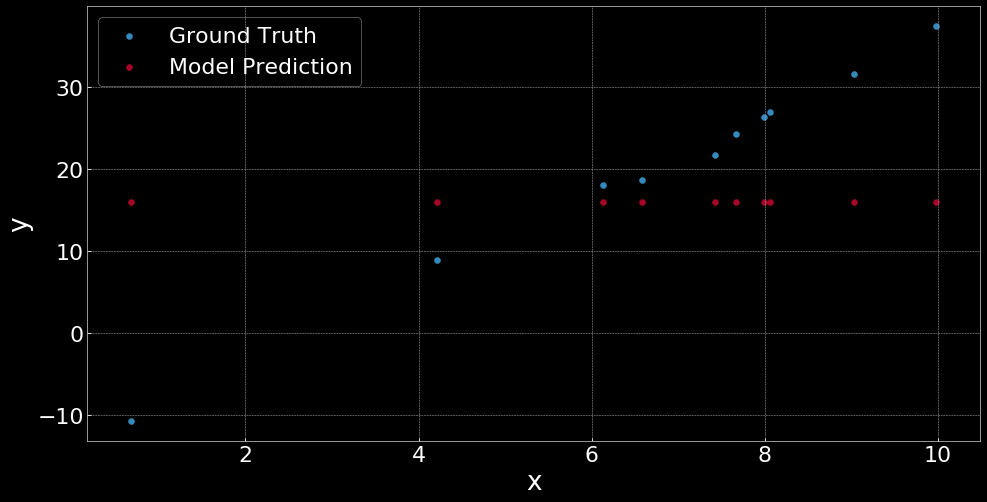

In [118]:
plt.scatter(x.detach().numpy(), y_true.detach().numpy(), label="Ground Truth")
plt.scatter(x.detach().numpy(), y_pred.detach().numpy(), label='Model Prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

And now we are done! "But wait!", surely you are saying. "This model is not any good! What if we just add a y-intercept into the model. This is surely not too complicated and will get much better performance!" I'm glad you said so! Let's go ahead and do that real quick...

In [97]:
theta = torch.Tensor(2).random_(20) # generate two theta values randomly between 0 and 19
theta.requires_grad = True # make sure we can compute the derivative/gradient of these parameters

In [98]:
slope = 4.928 # This is a parameter that our model needs to learn to predict accurately
y_intercept = -12.52 # This is another parameter that our model needs to learn to predict accurately
y_true = slope * x + y_intercept
y_true += noise
y_pred = theta[0] * x + theta[1]

In [99]:
loss_per_datapoint = (y_true - y_pred).pow(2)
loss = torch.sum(loss_per_datapoint) / (2 * N)

In [100]:
loss.backward() # remember to call this to make sure you compute the derivatives of loss to all your variables/parameters

In [101]:
theta.grad

tensor([-61.5730,  -4.3463])

But wait a second! We have two different derivatives now! How can that be...? How can a function have two different tangential slopes at a given point? Well, the problem is we have actually left the 2-dimensional world and have entered the realm of multivariate calculus or 3-dimensional functions. This is because our loss function is no longer a function of a single parameter, $\theta$, but rather two parameters, $\theta_1$ and $\theta_2$. Now, functions in 3-dimensions no longer have tangential *lines* but **tangential planes**. The equation for a plane in 3 dimensions, if you have never seen it before, is:
$$
z = f(x, y) = ax + by + c
$$
Look like the familiar $y = mx + b$? We can also define a plane in 3 dimensions by specifying two slopes that are orthogonal (90 degrees to one another) and a z-intercept, $c$. Therefore, the equation for a tangential plane is thus (substituting x = $\theta_1$ and y = $\theta_2$):
$$
z = \frac{\partial \mathcal{L}}{\partial \theta_1}\theta_1 + \frac{\partial \mathcal{L}}{\partial \theta_2}\theta_2 + c
$$

In fact, we can create a new object out of these derivatives called the *gradient*:
$$
\nabla \mathcal{L} = \langle \frac{\partial \mathcal{L}}{\partial \theta_1}, \frac{\partial \mathcal{L}}{\partial \theta_2} \rangle
$$
The gradient tells us in what direction to step in (how much in the $\theta_1$ direction and how much in the $\theta_2$ direction) in multiple dimensions in order to maximize our function. Imagine climbing up a hill. The quickest way up a hill would be to follow the gradient of the hill.

As before, as a concrete example we can use the function:
$$
\mathcal{L} = \theta_1^2 + \theta_2^2
$$
which has the gradient
$$
\nabla \mathcal{L} = \langle 2 \theta_1, 2\theta_2 \rangle
$$

In [103]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [134]:
def paraboloid_tangents(theta_1, theta_2, theta_1_range=1.0, theta_2_range=1.0):
    """
    Compute the tangential planes to the paraboloid L = (theta_1)^2 + (theta_2)^2
    
    :param theta_1: The theta_1 coordinate to plot the tangential plane at
    :param theta_2: The theta_2 coordinate to plot the tangential plane at
    :param theta_1_range: The range of theta_1 around the point to plot the tangential plane 
                            and loss surface at
    :param theta_2_range: The range of theta_2 around the point to plot the tangential plane
                            and loss surface at
    """
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"}) # set up the plotting to do 3D plotting
    L = theta_1 ** 2 + theta_2 ** 2 # compute our loss surface
    grad = (2 * theta_1, 2 * theta_2) # compute our gradient
    c = L - grad[0] * theta_1 - grad[1] * theta_2 # compute "z-intercept" of our tangential plane
    
    print('Gradient = ' + str(grad))
    
    # compute x-axis and y-axis values for plotting loss function surface and tangential plane
    X = np.arange(theta_1 - theta_1_range, theta_1 + theta_1_range, 0.01)
    Y = np.arange(theta_2 - theta_2_range, theta_2 + theta_2_range, 0.01)
    
    # compute all pairs of X and Y values for plotting
    X, Y = np.meshgrid(X, Y)
    
    # evaluate loss at all of these points
    LOSS = X ** 2 + Y ** 2
    
    # evaluate tangential plane at all of these points
    plane = grad[0] * X + grad[1] * Y + c
    
    # plot the loss surface
    surf = ax.plot_surface(X, Y, LOSS, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
    
    # plot the tangential plane surface
    surf2 = ax.plot_surface(X, Y, plane)
    plt.xlabel(r'$\theta_1$')
    plt.ylabel(r'$\theta_2$')
    ax.tick_params(axis='both', which='major', pad=-15)
    #plt.zlabel(r'$\mathcal{L}$')
    plt.show()
    

Gradient = (2, 2)


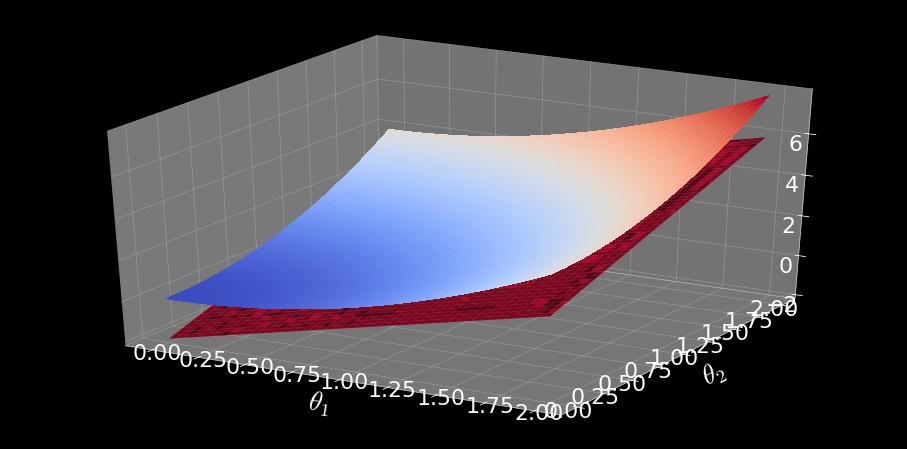

In [135]:
paraboloid_tangents(1, 1)

Gradient = (2, 2)


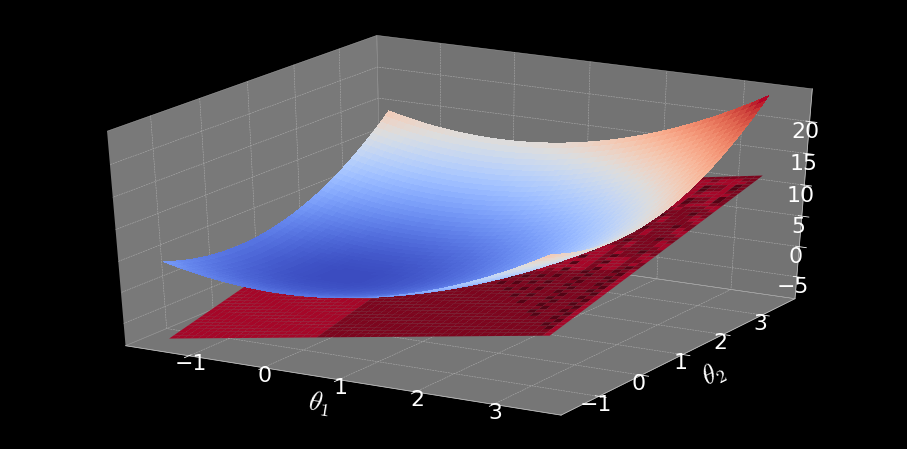

In [120]:
paraboloid_tangents(1, 1, theta_1_range=2.5, theta_2_range=2.5)

So now we know why there are two derivatives... it is just $\frac{\partial \mathcal{L}}{\partial \theta_1}$ and $\frac{\partial \mathcal{L}}{\partial \theta_2}$. However, we need to update our learning algorithm to include the generalization to multiple dimensions:

$$
\vec{\theta}_{t + 1} = \vec{\theta}_{t} - \alpha \nabla_{\vec{\theta}}\mathcal{L}
$$
where $\nabla_{\vec{\theta}}$ just means the gradient with respect to $\vec{\theta}$. This learning algorithm is called gradient descent! If we wanted to instead maximize a loss function $\mathcal{L}$, we would add the gradient and this would be gradient ascent. This is one of the most ubiquitous learning algorithms in machine learning and there exist many variants of learning algorithms that all employ information about the gradient (or higher order derivatives...Hessian anyone?) to teach the machine. These are called gradient-based learning algorithms, some of which we will discuss in the next lab.

Alright, so now let's finally train a model with two parameters!

In [121]:
losses = [] # array to store the loss at each time step for plotting
learning_rate = 0.01 # learning rate
T = 10000 # number of time steps to perform

# generate my theta vector consisting of two numbers generated randomly between 0 and 19
theta = torch.Tensor(2).random_(20) 

theta.requires_grad = True # make sure we compute the gradient

for t in range(T): # perform the time steps to update our theta vector
    y_pred = theta[0] * x + theta[1] # compute predicted y values
    loss_per_datapoint = (y_true - y_pred).pow(2) # compute loss per data point
    loss = torch.sum(loss_per_datapoint) / (2 * N) # compute average loss
    losses.append(loss) # add loss to our array of losses
    
    loss.backward() # compute gradient of loss with respect to all of our variables
    theta.data -= learning_rate * theta.grad.data # theta_{t+1} -= alpha * gradient_theta
    theta.grad = None # clear theta gradient so we can recompute at next time step

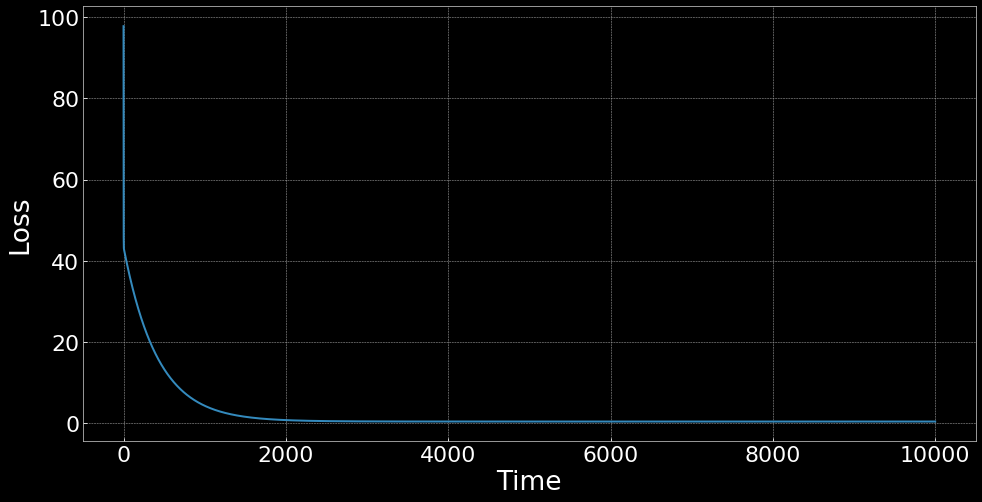

In [125]:
# seems it might have been finished learning at around t = ~2000?
t = np.arange(0, len(losses), 1)
plt.plot(t, losses)
plt.ylabel('Loss')
plt.xlabel('Time')
plt.show()

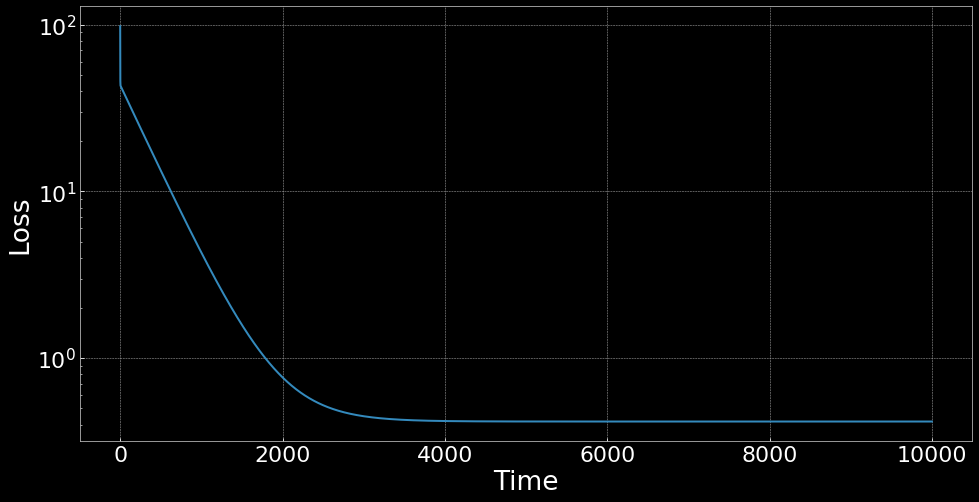

In [122]:
# plot on log axis to make sure learning converged
# should see it converged actually at t = ~4000
t = np.arange(0, len(losses), 1)
plt.plot(t, losses)
plt.ylabel('Loss')
plt.xlabel('Time')
plt.yscale('log')
plt.show()

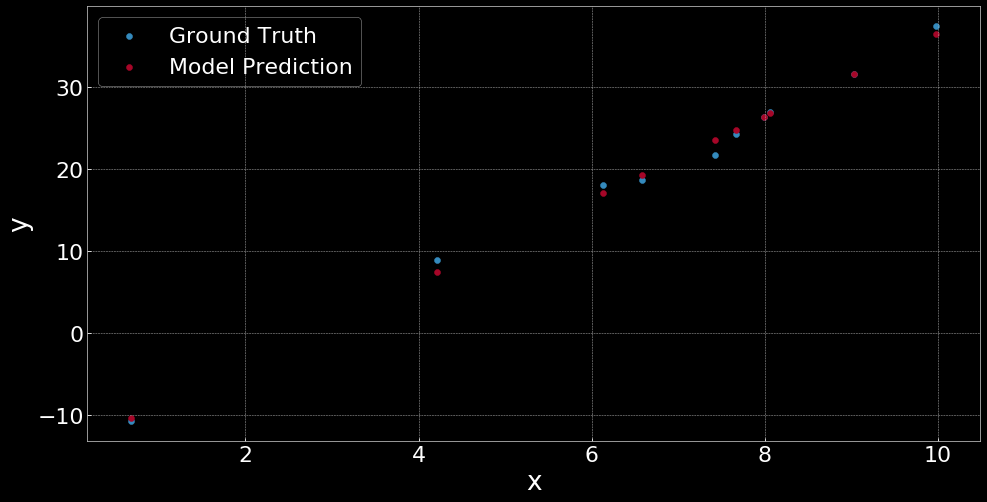

In [126]:
plt.scatter(x.detach().numpy(), y_true.detach().numpy(), label="Ground Truth")
plt.scatter(x.detach().numpy(), y_pred.detach().numpy(), label='Model Prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

Note that the loss plot is now plotted on a log axis. This is because if it is not on a log axis it is easy to assume that you may be finished training but the model's performance will still be sub-optimal. Go ahead and try messing with the learning rate and number of iterations (T) to see how loss changes and what the model looks like.

# We have trained our first machine learning model!

## Exercise 1
Create a linear regression model to fit the following `train_data` given the `y_true` ground truth values.

In [127]:
# Exercise 1
x = 5 * torch.rand(1000).reshape(1000, 1) # generate 1000 numbers between 0 and 5 and make it a 2D array 1000 x 1
y = 5 * torch.rand(1000).reshape(1000, 1) # generate 1000 numbers between 0 and 5 and make it a 2D array 1000 x 1
noise = torch.randn(1000).reshape(1000, 1) # generate 1000 numbers normally distributed and make it a 2D array 1000 x 1

train_data = torch.cat((x, y), dim=1) # put the x and y's together

y_true = 3.32 * x - 1.18 * y + 5.42
y_true += 2 * noise

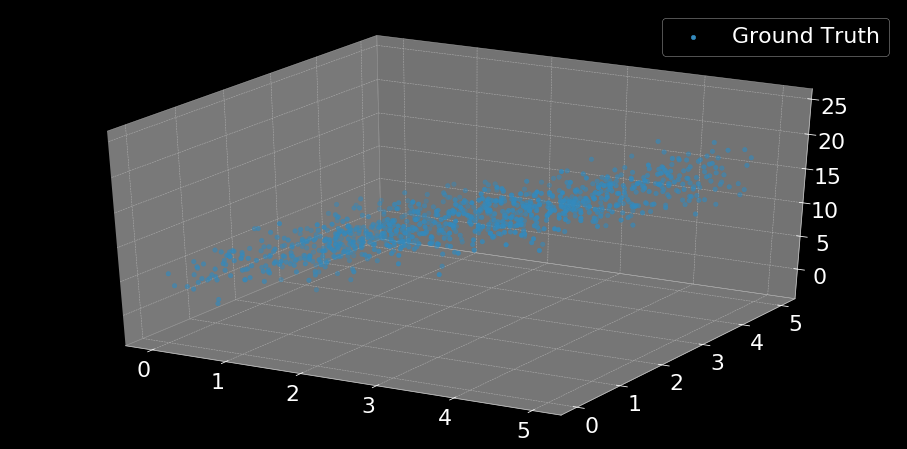

In [130]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}) # set-up plotting for 3D plotting

# .flatten() will turn a 2D array into a 1D array, necessary for plotting
surf = ax.scatter(x.numpy().flatten(), y.numpy().flatten(), y_true.numpy().flatten(), label='Ground Truth')
plt.legend()
plt.show()

In [25]:
# define your parameters here
theta = ______
theta.requires_grad = True

In [35]:
# put training loop here
losses = [] # save my losses in an array
learning_rate = 0.001 # define my learning rate
T = 10 # number of time steps

for t in range(T): # loop through time
    # CODE GOES HERE

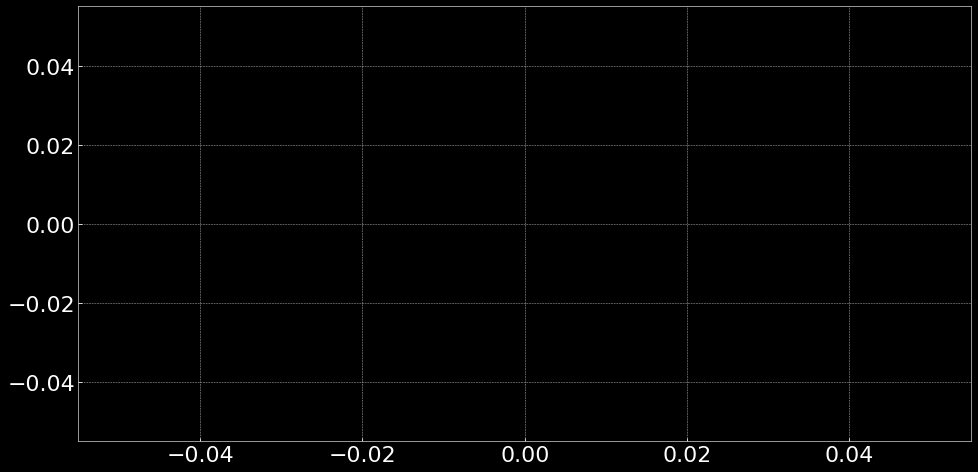

In [138]:
# plot loss as a function of time here
plt.plot()
plt.show()

In [137]:
# plot predictions vs ground truth here
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.scatter(x.numpy().flatten(), y.numpy().flatten(), y_true.numpy().flatten(), label='Ground Truth')
surf2 = ax.scatter(x.numpy().flatten(), y.numpy().flatten(), 'predictions here', label='Predictions')
plt.legend()
plt.show()

ValueError: could not convert string to float: 'predictions here'

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f17ce48b510> (for post_execute):


TypeError: Cannot cast array data from dtype('float64') to dtype('<U32') according to the rule 'safe'

TypeError: Cannot cast array data from dtype('float64') to dtype('<U32') according to the rule 'safe'

<Figure size 1152x576 with 1 Axes>

## Exercise 2
Try and create a linear regression for the following dataset that achieves a very low mean squared error loss. Hint: You can "augment" the training data however you please. This is a common practice called "feature engineering" where you try and make the data more easily learned by the machine learning model.

In [132]:
# Exercise 2
x = 2 * (torch.rand(1000).reshape(1000, 1) - 0.5)
y = 2 * (torch.rand(1000).reshape(1000, 1) - 0.5)
noise = torch.randn(1000).reshape(1000, 1)
train_data = torch.cat((x, y), dim=1)

y_true = (-10 * (x ** 2)) + (5 * (y ** 3))
y_true += noise

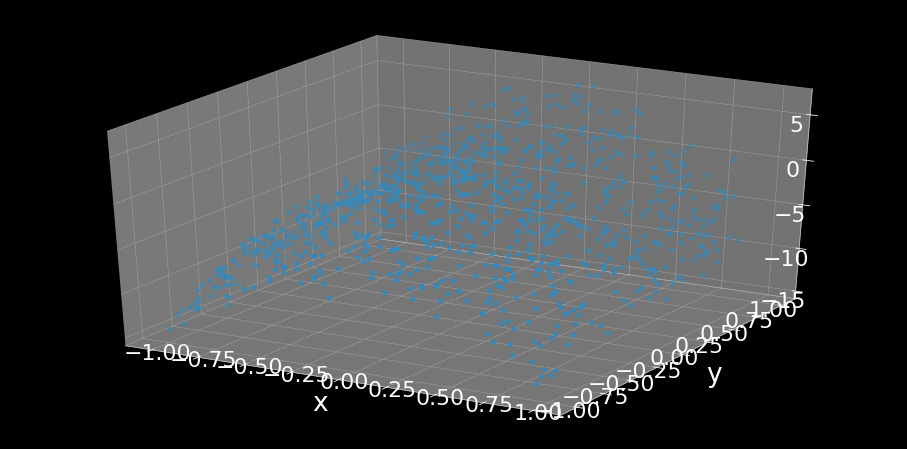

In [136]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
surf = ax.scatter(x.numpy().flatten(), y.numpy().flatten(), y_true.numpy().flatten())
ax.tick_params(axis='both', which='major', pad=-15) # moves tick labels inwards so you can see axis labels
plt.ylabel('y')
plt.xlabel('x')
plt.show()

In [ ]:
# put any data augmentation here
new_x = 
new_y = 
augmented_train_data = torch.cat((new_x, new_y))

In [ ]:
# define your model's parameters here
theta = 
theta.requires_grad = True

In [ ]:
# put training loop here
losses = []
learning_rate = 0.001
T = 10

for t in range(T):
    # CODE GOES HERE

In [ ]:
# plot loss as a function of time here
plt.plot()
plt.show()

In [ ]:
# plot predictions vs ground truth here
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}) # set-up plotting for 3D plotting

# create ground truth scatter plot
surf = ax.scatter(x.numpy().flatten(), y.numpy().flatten(), y_true.numpy().flatten(), label='Ground Truth')

# create predictions scatter plot
surf2 = ax.scatter(x.numpy().flatten(), y.numpy().flatten(), 'predictions here', label='Predictions')

# plot the legend
plt.legend()
plt.show()

## Exercise 3
I mentioned that another task is performing classification instead of linear regression. To perform classification you need to use a different function instead of the hyperplane (multidimensional line ;)). The simplest model for classification is the logistic function:
$$
\hat{y} = \frac{1}{1 - e^{-\vec{\theta} \cdot \vec{x}}}
$$
where the logistic function for 1D is:
$$
\hat{y} = \frac{1}{1 - e^{-\left(\theta_1 * x_1 + \theta_2\right)}}
$$

Use this function to classify the following 1D data:

Note: You will also likely want to use a different loss function than MSE. For binary classification (this task here), a common loss function used is Binary Cross-entropy (BCE):
$$
\mathcal{L} = -\frac{1}{N}\sum_{i=1}^{N} y_i log(\hat{y}_i) + (1 - y_i) log(1 - \hat{y}_i)
$$


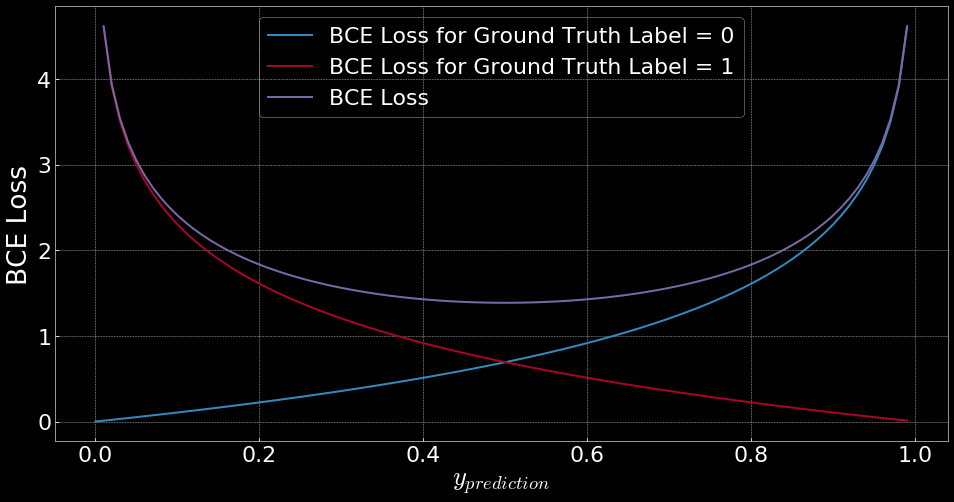

In [139]:
y_prediction = torch.arange(0, 1, 0.01) # generate prediction values between 0 and 1 in steps of 0.01
class_0_loss = -torch.log(1 - y_pred) # show component of loss for ground truth y = 0 class labels
class_1_loss = -torch.log(y_pred) # show component of loss for ground truth y = 1 class labels
plt.plot(y_pred.numpy(), class_0_loss.numpy(), label='BCE Loss for Ground Truth Label = 0')
plt.plot(y_pred.numpy(), class_1_loss.numpy(), label='BCE Loss for Ground Truth Label = 1')
plt.plot(y_pred.numpy(), (class_0_loss + class_1_loss).numpy(), label='BCE Loss')
plt.xlabel('$y_{prediction}$')
plt.ylabel('BCE Loss')
plt.legend()
plt.show()

In [141]:
x = 4 * (torch.rand(1000).reshape(1000, 1) - 0.5) # generate x values for our model to train on
noise = torch.randn(1000).reshape(1000, 1) / 4 # noise

y_true = (torch.sign(x + 1.5 + noise) + 1) / 2 # class labels, either 0 or 1

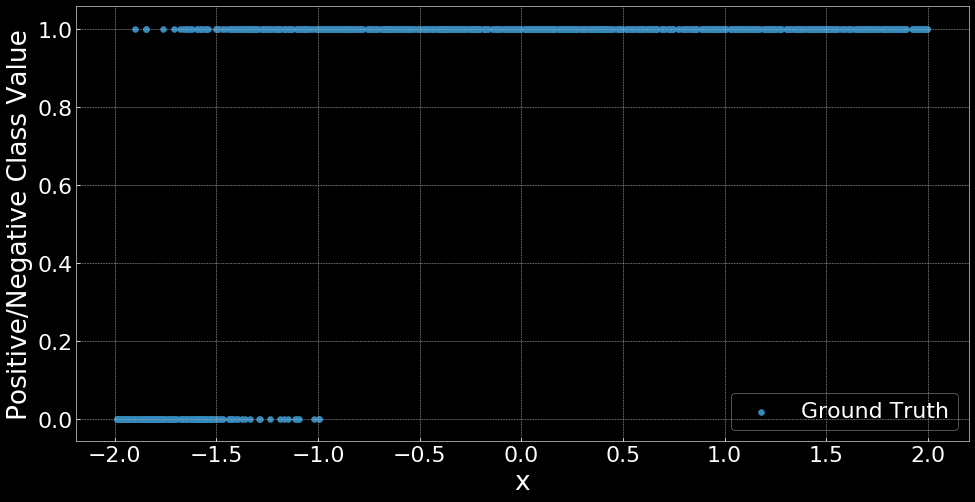

In [145]:
plt.scatter(x.numpy().flatten(), y_true.numpy().flatten(), label='Ground Truth')
plt.xlabel('x')
plt.ylabel('Positive/Negative Class Value')
plt.legend()
plt.show()

In [ ]:
# define your model's parameters here
theta = 
theta.requires_grad = True

In [ ]:
# put training loop here
losses = []
learning_rate = 0.001
T = 10

for t in range(T):
    # CODE GOES HERE

In [ ]:
# plot loss as a function of time here
plt.plot()
plt.show()

In [147]:
# plot predictions vs ground truth here
plt.scatter(x.numpy().flatten(), y_true.numpy().flatten(), label='Ground Truth')
plt.scatter(, , label='Predictions') # CODE GOES HERE
plt.xlabel('x')
plt.ylabel('Positive/Negative Class Value')
plt.legend()
plt.show()

SyntaxError: invalid syntax (<ipython-input-147-a8755bf688a1>, line 3)